We have a "problem" for $\nu=0.9$ because performance are really bad. In fact, this is not a problem and theory still stand but it's not statisfactory. The goal is to understand why for this kind of configuration, method doesn't work.

We think about :
+ big attraction local minimum at $s=0$ for $\nu=0.9$ compared to $ \nu=0.1$
+ big step from the proximal $s=0$ for $\nu=0.9$ compared to $\nu=0.1$
+ $\nu=0.1$ create a **global** minimum whereas $\nu=0.9$ is **not** a global minimum
+ $\lambda_0$ is more revelant than $\lambda_0^{local}$


So we will try to see numerically these differents ideas.

# Basic function

In [2]:
using LinearAlgebra, Statistics, Random, Printf, Plots, LaTeXStrings

In [3]:
include("../functions/ISTA.jl")
include("../functions/metrics.jl")

import .ISTA: ista_L, ista
import .metrics: pesr, tpr, fdr, f1score

In [4]:
rho(x, ν)  = abs(x) / (1 + abs(x)^(1-ν))
rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [5]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [6]:
function kappa_phi(Γ::Float64, ν::Float64)
    T = eps(Float64)
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, it = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))

    return κ, φ
end

kappa_phi (generic function with 1 method)

In [7]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

x_tar (generic function with 1 method)

In [8]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


prox_harder_vec (generic function with 1 method)

In [9]:
function lambda_local0(y, X; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / norm(r)
end

function lambda_qut_v(X; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_v (generic function with 1 method)

# 1. Landscape (lower dimension)

We work with $p=2$ so maybe its not relevant for general case in high dimension but it can be insightful.

λ = 5.8980278578271275


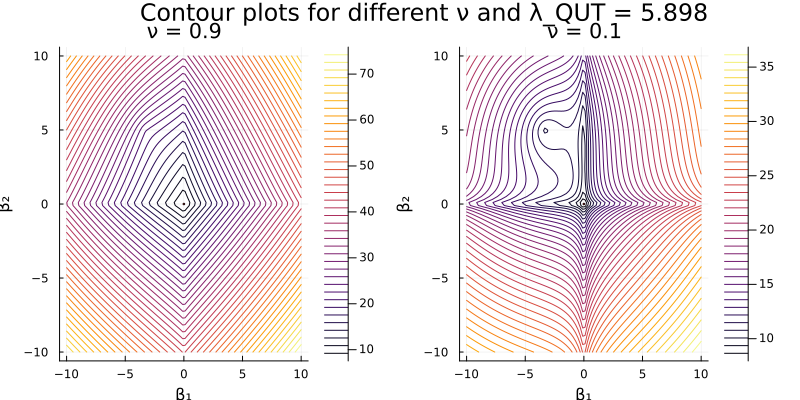

In [10]:

Random.seed!(42)
n, p = 2, 2
X = randn(n, p)
β_star = [0.0, 0.0] 
σ = 10
y= X*β_star .+ σ*randn(n)
λ = 5*lambda_qut_v(X; α = 0.05, M = 1000, verbose = false) 
print("λ = $λ\n")
νlist = [0.9, 0.1] 

ρ(x, ν) = abs(x)/(1 + abs(x)^(1-ν))

grid      = range(-10, 10; length = 100)
f(β1, β2, ν) = begin
    # β = SVector(β1, β2)                             # small stack-allocated vec
    β = [β1, β2]                             # small stack-allocated vec
    norm(y - X*β) + λ*sum(ρ.(β, ν))
end

contours = Plots.Plot[]
for ν in νlist
    fvals = [f(b1, b2, ν) for b2 in grid, b1 in grid]  # note ordering
    push!(contours,
          contour(grid, grid, fvals; levels = 40, title = "ν = $ν",
                  xlabel = "β₁", ylabel = "β₂", legend = true))
end
foreach(p -> scatter!(p, [β_star[1]], [β_star[2]]; m = (:red, :circle, 1)), contours)

Plots.plot(contours...;  plot_title = "Contour plots for different ν and λ_QUT = $(round(λ, digits=3))",
           size = (800, 400), layout = (1, 2), legend = false)


# 2. ISTA is stopping for $\nu=0.9$ in a local minimum or not ?

## Initialization ($s=0, \nu=0.9$)

In [60]:
n, p = 70, 250
s = 0
B_trial = 50
sigma = 0.1
ν = 0.9

0.9

## Experiment 

In [61]:
tol=1e-9
α=0.05
mu=1
c=0

X = randn(n, p)
X .-= mean(X; dims=1)
X ./= std(X;  dims=1)

β = zeros(p)
β[randperm(p)[1:s]] .= 3

n = size(X, 1)
X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
y = X * β .+ σ * mu *randn(n) .+ c

λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

f(θ) = norm(y - X̃ * θ, 2)
∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)

L0 = 1e-4
θ  = zeros(p + 1) 
g(θ) = λ_QUT * sum(rho.(θ[1:end-1], ν))  # penalty
prox( z,γ ) = prox_harder_vec(z, γ, λ, ν)

θ = ista(θ, f, g, ∇f, L0, prox; max_iter = 10_000 ,tol=tol,verbose  = false)
;

We look if the value predict by ISTA is lower than the expected value if we take the correct solution : with $s=0$ it's the null model so **0**.

In [62]:
println("PESR : $(pesr(β, θ[1:end-1]; tol=0))")
println("l1-norm of predicted features coeff $(sum(abs.(θ[1:end-1]))) ")

cost_value_pred = f(θ) + g(θ)
cost_value_expect = f(zeros(p+1)) + g(zeros(p+1))

println("Cost at prediction : $cost_value_pred"
        *"\nCost at expectation : $cost_value_expect")

PESR : 1.0
l1-norm of predicted features coeff 0.0 
Cost at prediction : 76.6994324994111
Cost at expectation : 76.7210680805708


So ISTA converge well towards a local minimum and surely global. This one is a "better" minimum than what we expected : fall in the minimum create in **0**.

So, for me, no math/informatic problem, $\lambda_{QUT}$ create a minimum local in $0$ but ISTA doesn't converge inside (Despite it start to this local minimum : the first step of proximal should be too big and escape this bassin created in 0)

<span style="color:red"><b>TODO :</b></span> be sure where we fall is a minimum local or at least empirically : find a "test".  
Idea : make a little shift in all direction (or in many direction) and still have a cost value bigger than the point considerated as a local minimum.
